# U-Net Brain Tumor Segmentation

In [21]:
import tensorflow as tf
import keras
from keras.callbacks import Callback
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard

import numpy as np
import os
import SimpleITK as sitka
import random
import matplotlib.pyplot as plt
import importlib
import time

# Data augmentation
import cv2
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate, ElasticTransform, Rotate, RandomScale, GridDistortion, OpticalDistortion, OneOf
)

# Custom scripts
import datagen
import model as unet_model_script

# Reload lib contents
importlib.reload(datagen)
importlib.reload(unet_model_script)

<module 'model' from 'C:\\Users\\krcma\\Desktop\\tf_segmentation\\unet_segmentation\\model.py'>

##  Hyperparemeters

In [22]:
train_HGG_patients = 239
valid_HGG_patients = 20
slices_from_patient = 15

slices_from = 60
slices_to = 100

image_size = 240
channels = 4
learning_rate = 1e-4
epochs = 25
batch_size = 7


### U-Net model parameters

Configuration dict.

In [23]:
conf = {
    "last_layer_activation": "sigmoid",
    "dropout": 0.05,
    "batch_norm": True
}

In [24]:
training_model_conf = {
    "optimizer": keras.optimizers.Adam(learning_rate=learning_rate),
    "loss": "binary_crossentropy",
    "metrics": ["accuracy"]
}

## Dataset

In [25]:
x_train, y_train = datagen.get_dataset(slices_from_patient,
                                        slices_from, slices_to,
                                        file_path='../dataset/', 
                                        mode='training', 
                                       tumor_region=3,
                                        glioma_type=['HGG'], 
                                        slices_w_tumor_only=100,
                                        slices_w_less_brain=None,
                                        image_size=image_size,
                                        train_HGG_patients=train_HGG_patients)

training data with shape: (3585, 4, 240, 240) (3585, 1, 240, 240)


In [26]:
x_valid, y_valid = datagen.get_dataset(slices_from_patient, 
                                       slices_from, slices_to,
                                        file_path='../dataset/', 
                                        mode='validation', 
                                       tumor_region=3,
                                        glioma_type=['HGG'], 
                                        slices_w_tumor_only=False,
                                        slices_w_less_brain=100,
                                        image_size=image_size,
                                        train_HGG_patients=valid_HGG_patients)

validation data with shape: (300, 4, 240, 240) (300, 1, 240, 240)


## Data augmentation

In [27]:
AUGMENTATIONS = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
#     Rotate(limit=90, p=0.99),
#     RandomGamma(gamma_limit=(80, 120), p=0.25),
#     RandomScale(scale_limit=0.1, interpolation=cv2.INTER_NEAREST, p=0.25),
#     ElasticTransform(alpha=1, p=0.5),
#     OneOf([
#         OpticalDistortion(p=0.3),
#         GridDistortion(p=0.1),
#     ], p=0.2),
    OpticalDistortion(p=0.5),
    GridDistortion(p=0.5),
])

## Callbacks

In [28]:
class NegativeLoss(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        pass

    def on_batch_end(self, batch, logs={}):
        if logs.get('loss') < 0:
            print("\nEarly stopping for negative loss ({}) at batch {}.".format(logs.get('loss'), batch))
            self.model.stop_training = True

callbacks = [
    NegativeLoss(),
    keras.callbacks.callbacks.TerminateOnNaN(),
    keras.callbacks.callbacks.EarlyStopping(monitor='accuracy', 
                                            min_delta=0.0001, 
                                            patience=10, 
                                            verbose=1, 
                                            mode='auto', 
                                            baseline=None, 
                                            restore_best_weights=True),
    keras.callbacks.callbacks.ReduceLROnPlateau(factor=0.1, 
                                                patience=5, 
                                                min_lr=0.00001, 
                                                verbose=1),
#     keras.callbacks.TensorBoard(log_dir="../logs/{}".format(time.time()))
]

# Ensemble training

In [29]:
models = {}
for tumor_region in range(3, 4):
    
    print("Training U-Net {}".format(tumor_region))
    
    # Get and compile model
    models[tumor_region] = unet_model_script.UNet(channels, image_size, conf=conf)
    models[tumor_region].compile(**training_model_conf)
    
    # Convert mask labels to binary
    train_masks = datagen.convert_labels(y_train, tumor_region, image_size)
    valid_masks = datagen.convert_labels(y_valid, tumor_region, image_size)
    
    # Init datagen w augmentation
    train_gen = datagen.AugmentationDatagen(x_train, train_masks, batch_size, AUGMENTATIONS)
    
    # Start training
    time_start = time.time()
    models["hist_{}".format(tumor_region)] = models[tumor_region].fit(train_gen, 
                                                                      validation_data=(x_valid, valid_masks), 
                                                                      epochs=epochs, 
                                                                      shuffle=True, 
                                                                      callbacks=callbacks)
    print("Training time: {}".format(time.time()-time_start))
    
    models[tumor_region].save("../experiment_data_selection/unet_3.h5")    

Training U-Net 3
Epoch 1/25
513/513 [==============================] - 266s 519ms/step - loss: 0.1504 - accuracy: 0.9856 - val_loss: 0.0974 - val_accuracy: 0.9942
Epoch 2/25
513/513 [==============================] - 258s 503ms/step - loss: 0.0606 - accuracy: 0.9939 - val_loss: 0.1103 - val_accuracy: 0.9946
Epoch 3/25
513/513 [==============================] - 258s 503ms/step - loss: 0.0376 - accuracy: 0.9944 - val_loss: 0.0284 - val_accuracy: 0.9960
Epoch 4/25
513/513 [==============================] - 256s 499ms/step - loss: 0.0272 - accuracy: 0.9950 - val_loss: 0.0311 - val_accuracy: 0.9946
Epoch 5/25
513/513 [==============================] - 255s 497ms/step - loss: 0.0212 - accuracy: 0.9953 - val_loss: 0.0167 - val_accuracy: 0.9962
Epoch 6/25
513/513 [==============================] - 256s 498ms/step - loss: 0.0177 - accuracy: 0.9955 - val_loss: 0.0250 - val_accuracy: 0.9959
Epoch 7/25
513/513 [==============================] - 259s 505ms/step - loss: 0.0154 - accuracy: 0.9957 - v

### Results

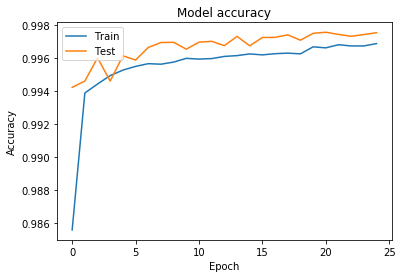

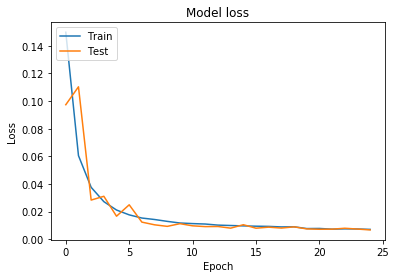

In [30]:
tumor_region = 3

# Plot training & validation accuracy values
plt.plot(models["hist_{}".format(tumor_region)].history['accuracy'])
plt.plot(models["hist_{}".format(tumor_region)].history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(models["hist_{}".format(tumor_region)].history['loss'])
plt.plot(models["hist_{}".format(tumor_region)].history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
# i = random.randint(0, 50)
# i = 3
# pred = models[1].predict(np.array([x_valid[i]]), verbose=1)
# f, axarr = plt.subplots(1,2, figsize=(10,10))
# axarr[0].imshow(y_valid[i][0])
# axarr[1].imshow(pred[0][0])